# Experiments on InceptionV3

In [2]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import pandas as pd
import os
from skimage import io
import torch
from skimage import color
import pickle
from copy import deepcopy
from sklearn.metrics import roc_auc_score, f1_score

## Check if Running on GPU and Define Training Loop

In [3]:
if torch.cuda.is_available:
    print('Running on GPU.')
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found. Running on CPU.')
    device = torch.device('cpu')

Running on GPU.
Tesla V100-PCIE-32GB


In [4]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs = 50, verbose = False):
    f1_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_loss = np.inf
    best_f1 = 0
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for phase in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            all_preds = []
            all_labels = []
            if phase == 'train':
                model.train()
                for data in dataloader[phase]:
                    optimizer.zero_grad()
                    image = data['x'].to(device)
                    label = data['y'].to(device)
                    logits = model(image).logits
                    loss = loss_fn(logits, label)
                    _, preds = torch.max(logits, dim = 1)
                    num_imgs = image.size()[0]
                    running_correct += torch.sum(preds == label).item()
                    running_loss += loss.item()*num_imgs
                    running_total += num_imgs
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(label.cpu().numpy())
                    
                    loss.backward()
                    optimizer.step()
                    
                epoch_acc = float(running_correct/running_total)
                epoch_loss = float(running_loss/running_total)
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                if verbose or (i%10 == 0):
                    print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_f1))

                f1_dict[phase].append(epoch_f1)
                loss_dict[phase].append(epoch_loss)

            # Auxiliary classifier is turned off during evaluation
            else:
                model.eval()
                with torch.no_grad():
                    for data in dataloader[phase]:
                        image = data['x'].to(device)
                        label = data['y'].to(device)
                        logits = model(image)
                        loss = loss_fn(logits, label)
                        _, preds = torch.max(logits, dim = 1)
                        num_imgs = image.size()[0]
                        running_correct += torch.sum(preds == label).item()
                        running_loss += loss.item()*num_imgs
                        running_total += num_imgs
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(label.cpu().numpy())
        
                epoch_acc = float(running_correct/running_total)
                epoch_loss = float(running_loss/running_total)
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                if verbose or (i%10 == 0):
                    print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_f1))

                f1_dict[phase].append(epoch_f1)
                loss_dict[phase].append(epoch_loss)
                if epoch_f1 > best_f1:
                    best_loss = epoch_loss
                    best_model_wts = deepcopy(model.state_dict())
                    best_f1 = epoch_f1
                    best_acc = epoch_acc

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Selected model val acc: {:4f} Selected model val F1: {:4f}'.format(best_acc, best_f1))
    
    model.load_state_dict(best_model_wts)
    
    return model, f1_dict, loss_dict

## Small Sample of HAM10000

In [6]:
# Get random small sample of the data
train_df_path = 'train.csv'
val_df_path = 'validation.csv'
test_df_path = 'test.csv'

train_df = pd.read_csv(train_df_path)
val_df = pd.read_csv(val_df_path)
test_df = pd.read_csv(test_df_path)

train_sample = train_df.sample(frac=0.15, random_state=48)
val_sample = val_df.sample(frac=0.15, random_state=48)
test_sample = test_df.sample(frac=0.15, random_state=48)

print('\nSample Train set class distribution:')
print(train_sample['Class'].value_counts(normalize=True))
print(train_sample['Class'].value_counts(normalize=False))
print('\nSample Validation set class distribution:')
print(val_sample['Class'].value_counts(normalize=True))
print(val_sample['Class'].value_counts(normalize=False))
print('\nSample Test set class distribution:')
print(test_sample['Class'].value_counts(normalize=True))
print(test_sample['Class'].value_counts(normalize=False))


Sample Train set class distribution:
Class
5    0.690995
2    0.106161
4    0.104265
1    0.047393
0    0.026540
3    0.015166
6    0.009479
Name: proportion, dtype: float64
Class
5    729
2    112
4    110
1     50
0     28
3     16
6     10
Name: count, dtype: int64

Sample Validation set class distribution:
Class
5    0.648649
4    0.114865
2    0.074324
0    0.060811
1    0.047297
6    0.027027
3    0.027027
Name: proportion, dtype: float64
Class
5    96
4    17
2    11
0     9
1     7
6     4
3     4
Name: count, dtype: int64

Sample Test set class distribution:
Class
5    0.698997
2    0.103679
1    0.066890
4    0.066890
0    0.030100
6    0.023411
3    0.010033
Name: proportion, dtype: float64
Class
5    209
2     31
1     20
4     20
0      9
6      7
3      3
Name: count, dtype: int64


In [7]:
# Save to CSV
train_sample.to_csv('sample_train.csv', index=False)
val_sample.to_csv('sample_validation.csv', index=False)
test_sample.to_csv('sample_test.csv', index=False)

## Dataset and Dataloader

In [5]:
def class_label(label):
    if label == 'akiec':
        label = 0
    elif label == 'bcc':
        label = 1
    elif label == 'bkl':
        label = 2
    elif label == 'df':
        label = 3
    elif label == 'mel':
        label = 4
    elif label == 'nv':
        label = 5
    elif label == 'vasc':
        label = 6
    return label

# Cropped for InceptionV3, Non-augmented data
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299),  
    transforms.CenterCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299), 
    transforms.CenterCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = load_data_and_get_class(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1]+'.jpg')
        
        image = io.imread(img_name)
        if len(image.shape) > 2 and image.shape[2] == 4:
            image = image[:,:,0]
            
        image_class = self.data_frame.iloc[idx, -1]
        
        if self.transform:
            image = self.transform(image)

        sample = {'x': image, 'y': image_class}

        return sample

def load_data_and_get_class(path_to_data):
    data = pd.read_csv(path_to_data)
    data['Class'] = data['dx'].apply(class_label)
    return data

## Learning Rate/Batch Size Tuning

In [10]:
# Use if auxiliary classifiers are not needed
# self.inception.aux_logits = False
# self.inception.AuxLogits = None

In [6]:
class InceptionV3(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

In [12]:
batch_sizes = [16, 32, 64]
learning_rates = [0.00001, 0.0001, 0.001]

random_train_df_path = 'sample_train.csv'
random_val_df_path = 'sample_validation.csv'
root_image_directory = '/vast/amh9750/DL4MED_Project/DL4MED_Data/HAM10000/SkinCancer/Images'
sample_dataset = {'train': HAM10000Dataset(random_train_df_path, root_image_directory, train_transform),
                  'validate': HAM10000Dataset(random_val_df_path, root_image_directory, validation_transform)}

f1_dicts = []
loss_dicts = []
val_auc = []
train_auc = []
val_f1 = []
train_f1 = []

for batch_size in batch_sizes:
    sample_dataloader = {x: DataLoader(sample_dataset[x], batch_size=batch_size, shuffle=True) for x in ['train', 'validate']}
    
    lr_f1_dict = []
    lr_loss_dict = []
    lr_val_auc = []
    lr_train_auc = []
    lr_val_f1 = []
    lr_train_f1 = []
    
    for learning_rate in learning_rates:

        print('-'*50)
        print(f'learning rate={learning_rate} and batch_size={batch_size}')
        print('-'*50)

        tune_model = InceptionV3().to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(tune_model.parameters(), lr=learning_rate) 

        tune_model_out, tune_f1_dict, tune_loss_dict = train_model(tune_model, sample_dataloader, optimizer, loss_fn, num_epochs=20, verbose = False)
        
        lr_f1_dict.append(tune_f1_dict)
        lr_loss_dict.append(tune_loss_dict)
        
        # AUC for train dataset
        tune_model_out.eval()
        train_predictions = []
        train_targets = []
        for data in sample_dataloader['train']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)
            train_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            train_targets.extend(label.cpu().detach().numpy())

        train_auc_score = roc_auc_score(np.array(train_targets), np.array(train_predictions), average='macro', multi_class='ovr')
        train_f1_score = f1_score(np.array(train_targets), np.argmax(np.array(train_predictions), axis=1), average='macro')
        print(f'Train AUC for lr={learning_rate} and batch_size={batch_size}:\n{train_auc_score:.2f}')
        print(f'Train F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{train_f1_score:.2f}')
        lr_train_auc.append(train_auc_score)
        lr_train_f1.append(train_f1_score)
        

        # AUC for val dataset
        tune_model_out.eval()
        val_predictions = []
        val_targets = []
        for data in sample_dataloader['validate']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)

            val_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            val_targets.extend(label.cpu().detach().numpy())

        val_auc_score = roc_auc_score(np.array(val_targets), np.array(val_predictions), average='macro', multi_class='ovr')
        val_f1_score = f1_score(np.array(val_targets), np.argmax(np.array(val_predictions), axis=1), average='macro')
        print(f'Val AUC for lr={learning_rate} and batch_size={batch_size}:\n{val_auc_score:.2f}')
        print(f'Val F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{val_f1_score:.2f}')
        lr_val_auc.append(val_auc_score)
        lr_val_f1.append(val_f1_score)

    f1_dicts.append(lr_f1_dict)
    loss_dicts.append(lr_loss_dict)
    val_auc.append(lr_val_auc)
    train_auc.append(lr_train_auc)
    val_f1.append(lr_val_f1)
    train_f1.append(lr_train_f1)

with open('Inception_Models_F1/tuning_sample_pretrained.pkl', 'wb') as f:
    pickle.dump((f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1), f)

--------------------------------------------------
learning rate=1e-05 and batch_size=16
--------------------------------------------------
Epoch: 0/19
----------
Phase:train, epoch loss: 1.8474 Acc: 0.2815 F1: 0.1215
Phase:validate, epoch loss: 1.6284 Acc: 0.5541 F1: 0.1781
Epoch: 1/19
----------
Epoch: 2/19
----------
Epoch: 3/19
----------
Epoch: 4/19
----------
Epoch: 5/19
----------
Epoch: 6/19
----------
Epoch: 7/19
----------
Epoch: 8/19
----------
Epoch: 9/19
----------
Epoch: 10/19
----------
Phase:train, epoch loss: 0.3763 Acc: 0.9100 F1: 0.5237
Phase:validate, epoch loss: 0.9373 Acc: 0.6757 F1: 0.2641
Epoch: 11/19
----------
Epoch: 12/19
----------
Epoch: 13/19
----------
Epoch: 14/19
----------
Epoch: 15/19
----------
Epoch: 16/19
----------
Epoch: 17/19
----------
Epoch: 18/19
----------
Epoch: 19/19
----------
Training complete in 5m 10s
Selected model val acc: 0.689189 Selected model val F1: 0.359627
Train AUC for lr=1e-05 and batch_size=16:
1.00
Train F1 Score for lr=1e

In [13]:
with open('Inception_Models_F1/tuning_sample_pretrained.pkl', 'rb') as f:
    f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1 = pickle.load(f)

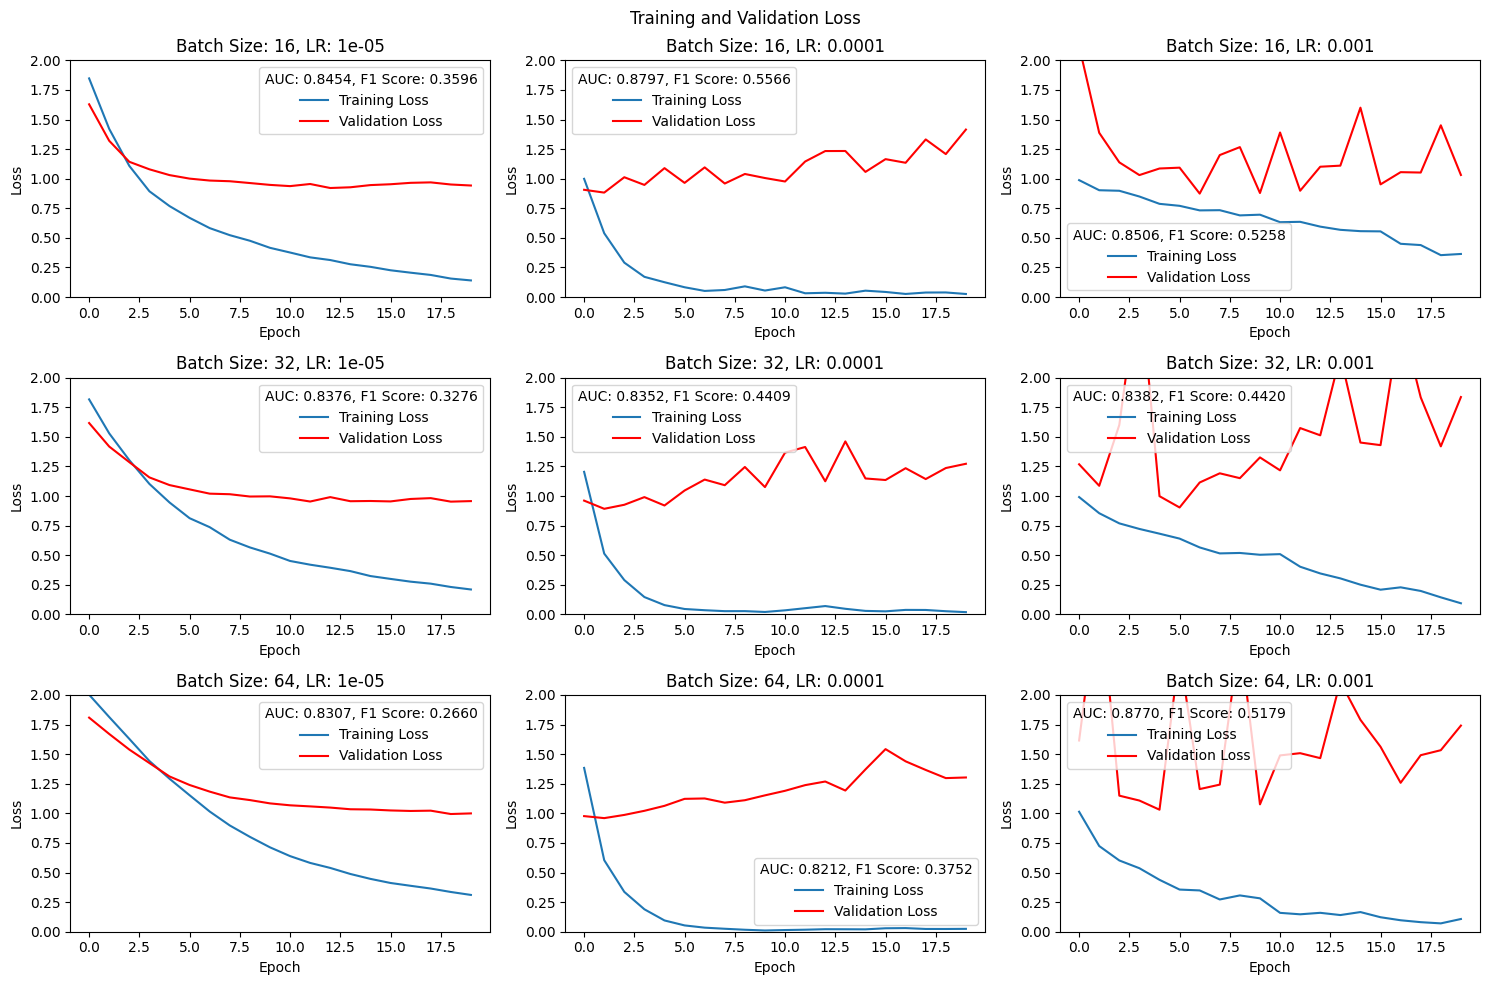

In [14]:
batch_sizes = [16, 32, 64]
learning_rates = [0.00001, 0.0001, 0.001] 

fig, axs = plt.subplots(len(batch_sizes), len(learning_rates), figsize=(15, 10))
plt.suptitle('Training and Validation Loss')

for i, batch_size in enumerate(batch_sizes):
    for j, learning_rate in enumerate(learning_rates):
        axs[i,j].plot(loss_dicts[i][j]['train'], label='Training Loss')
        axs[i,j].plot(loss_dicts[i][j]['validate'], label='Validation Loss', color='red')
        axs[i,j].set_title(f'Batch Size: {batch_size}, LR: {learning_rate}')
        axs[i,j].set_xlabel('Epoch')
        axs[i,j].set_ylabel('Loss')
        axs[i,j].set_ylim(0,2)
        axs[i, j].legend(title=f'AUC: {val_auc[i][j]:.4f}, F1 Score: {val_f1[i][j]:.4f}')

plt.tight_layout()
plt.savefig('Inception_Models_F1/hyperparameter_tuning_loss_pretrained.png')
plt.show()

## Full Data: Dataset and DataLoader

In [7]:
best_bs_pretrained = 16
best_lr_pretrained = 0.0001

train_df_path = 'train.csv'
val_df_path = 'validation.csv'
test_df_path = 'test.csv'
root_image_directory = '/vast/amh9750/DL4MED_Project/DL4MED_Data/HAM10000/SkinCancer/Images'

inception_transformed_dataset = {'train': HAM10000Dataset(train_df_path, root_image_directory, train_transform),
                       'validate': HAM10000Dataset(val_df_path, root_image_directory, validation_transform),
                        'test': HAM10000Dataset(test_df_path, root_image_directory, validation_transform)}
inception_dataloader = {x: DataLoader(inception_transformed_dataset[x], batch_size=best_bs_pretrained, shuffle=True) for x in ['train', 'validate','test']}

## Experiment 1-1: Training From Scratch

In [16]:
# InceptionV3 model from scratch
class InceptionV3Scratch(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3Scratch, self).__init__()
        self.inception = models.inception_v3(pretrained=False)
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

In [17]:
inceptionv3_model_1 = InceptionV3Scratch().to(device)
loss_fn = nn.CrossEntropyLoss()
inceptionv3_optimizer_1 = optim.Adam(inceptionv3_model_1.parameters(), lr=best_lr_pretrained) 

/ext3/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ext3/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/ext3/miniconda3/lib/python3.12/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [18]:
inceptionv3_model_out_1, inceptionv3_f1_dict_1, inceptionv3_loss_dict_1 = train_model(inceptionv3_model_1, 
                                                                                       inception_dataloader, 
                                                                                       inceptionv3_optimizer_1, 
                                                                                       loss_fn, 
                                                                                       num_epochs=20, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_1_2.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_1, inceptionv3_loss_dict_1), f)

# Save with torch
torch.save(inceptionv3_model_out_1.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_1_2.pth')
torch.save(inceptionv3_model_out_1, 'Inception_Models_F1/inceptionv3_model_1_2.pth')

Epoch: 0/19
----------
Phase:train, epoch loss: 0.9296 Acc: 0.6686 F1: 0.2437
Phase:validate, epoch loss: 0.9110 Acc: 0.7162 F1: 0.2425
Epoch: 1/19
----------
Phase:train, epoch loss: 0.8013 Acc: 0.7028 F1: 0.3586
Phase:validate, epoch loss: 1.0248 Acc: 0.7152 F1: 0.3033
Epoch: 2/19
----------
Phase:train, epoch loss: 0.7751 Acc: 0.7099 F1: 0.3798
Phase:validate, epoch loss: 0.7903 Acc: 0.7333 F1: 0.3386
Epoch: 3/19
----------
Phase:train, epoch loss: 0.7415 Acc: 0.7200 F1: 0.4102
Phase:validate, epoch loss: 0.9452 Acc: 0.7333 F1: 0.3780
Epoch: 4/19
----------
Phase:train, epoch loss: 0.7268 Acc: 0.7283 F1: 0.4280
Phase:validate, epoch loss: 0.8054 Acc: 0.7283 F1: 0.3770
Epoch: 5/19
----------
Phase:train, epoch loss: 0.6998 Acc: 0.7351 F1: 0.4412
Phase:validate, epoch loss: 0.8154 Acc: 0.7333 F1: 0.3941
Epoch: 6/19
----------
Phase:train, epoch loss: 0.6829 Acc: 0.7482 F1: 0.4772
Phase:validate, epoch loss: 0.8036 Acc: 0.7364 F1: 0.4264
Epoch: 7/19
----------
Phase:train, epoch loss: 

## Experiment 1-2: Finetuning - Updating Pretrained Weights

In [8]:
class InceptionV3(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

In [20]:
inceptionv3_model_2 = InceptionV3().to(device)
loss_fn = nn.CrossEntropyLoss()
inceptionv3_optimizer_2 = optim.Adam(inceptionv3_model_2.parameters(), lr=best_lr_pretrained) 

In [21]:
inceptionv3_model_out_2, inceptionv3_f1_dict_2, inceptionv3_loss_dict_2 = train_model(inceptionv3_model_2, 
                                                                                       inception_dataloader, 
                                                                                       inceptionv3_optimizer_2, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_2_2.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_2, inceptionv3_loss_dict_2), f)

# Save with torch
torch.save(inceptionv3_model_out_2.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_2_2.pth')
torch.save(inceptionv3_model_out_2, 'Inception_Models_F1/inceptionv3_model_2_2.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.7027 Acc: 0.7557 F1: 0.4618
Phase:validate, epoch loss: 0.5382 Acc: 0.8343 F1: 0.6021
Epoch: 1/14
----------
Phase:train, epoch loss: 0.3985 Acc: 0.8632 F1: 0.7241
Phase:validate, epoch loss: 0.5383 Acc: 0.8141 F1: 0.5889
Epoch: 2/14
----------
Phase:train, epoch loss: 0.2498 Acc: 0.9134 F1: 0.8597
Phase:validate, epoch loss: 0.5721 Acc: 0.8131 F1: 0.6240
Epoch: 3/14
----------
Phase:train, epoch loss: 0.1476 Acc: 0.9480 F1: 0.9228
Phase:validate, epoch loss: 0.5552 Acc: 0.8374 F1: 0.6307
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1163 Acc: 0.9598 F1: 0.9343
Phase:validate, epoch loss: 0.6480 Acc: 0.8192 F1: 0.6383
Epoch: 5/14
----------
Phase:train, epoch loss: 0.0976 Acc: 0.9664 F1: 0.9521
Phase:validate, epoch loss: 0.6785 Acc: 0.8152 F1: 0.6264
Epoch: 6/14
----------
Phase:train, epoch loss: 0.0637 Acc: 0.9790 F1: 0.9642
Phase:validate, epoch loss: 0.7657 Acc: 0.8394 F1: 0.6604
Epoch: 7/14
----------
Phase:train, epoch loss: 

## Experiment 1-3: Linear Probing

In [22]:
class InceptionV3LP(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3LP, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        for param in self.inception.parameters():
            param.requires_grad = False
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

In [23]:
inceptionv3_model_3 = InceptionV3LP().to(device)
loss_fn = nn.CrossEntropyLoss()
inceptionv3_optimizer_3 = optim.Adam(inceptionv3_model_3.parameters(), lr=best_lr_pretrained) 

In [24]:
inceptionv3_model_out_3, inceptionv3_f1_dict_3, inceptionv3_loss_dict_3 = train_model(inceptionv3_model_3, 
                                                                                       inception_dataloader, 
                                                                                       inceptionv3_optimizer_3, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_3.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_3, inceptionv3_loss_dict_3), f)

# Save with torch
torch.save(inceptionv3_model_out_3.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_3.pth')
torch.save(inceptionv3_model_out_3, 'Inception_Models_F1/inceptionv3_model_3.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 1.1226 Acc: 0.6602 F1: 0.1185
Phase:validate, epoch loss: 0.9777 Acc: 0.7020 F1: 0.1207
Epoch: 1/14
----------
Phase:train, epoch loss: 0.9994 Acc: 0.6697 F1: 0.1334
Phase:validate, epoch loss: 0.9128 Acc: 0.7051 F1: 0.1317
Epoch: 2/14
----------
Phase:train, epoch loss: 0.9394 Acc: 0.6815 F1: 0.1717
Phase:validate, epoch loss: 0.8712 Acc: 0.7162 F1: 0.1584
Epoch: 3/14
----------
Phase:train, epoch loss: 0.9161 Acc: 0.6852 F1: 0.1891
Phase:validate, epoch loss: 0.8500 Acc: 0.7182 F1: 0.1782
Epoch: 4/14
----------
Phase:train, epoch loss: 0.8864 Acc: 0.6919 F1: 0.2137
Phase:validate, epoch loss: 0.8314 Acc: 0.7222 F1: 0.1922
Epoch: 5/14
----------
Phase:train, epoch loss: 0.8669 Acc: 0.6961 F1: 0.2272
Phase:validate, epoch loss: 0.8196 Acc: 0.7273 F1: 0.2164
Epoch: 6/14
----------
Phase:train, epoch loss: 0.8534 Acc: 0.7008 F1: 0.2438
Phase:validate, epoch loss: 0.8121 Acc: 0.7313 F1: 0.2562
Epoch: 7/14
----------
Phase:train, epoch loss: 

## Experiment 2: Finetuning with Data Augmentation

### Experiment 2-1: 

In [28]:
# Augmentation transform
augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(299), 
    transforms.RandomHorizontalFlip(), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [29]:
inception_augmented_dataset = {'train': HAM10000Dataset(train_df_path, root_image_directory, augmentation_transform),
                       'validate': HAM10000Dataset(val_df_path, root_image_directory, validation_transform),
                        'test': HAM10000Dataset(test_df_path, root_image_directory, validation_transform)}
inception_augmented_dataloader = {x: DataLoader(inception_augmented_dataset[x], batch_size=best_bs_pretrained, shuffle=True) for x in ['train', 'validate','test']}

In [30]:
inceptionv3_model_5 = InceptionV3().to(device)
loss_fn = nn.CrossEntropyLoss()
inceptionv3_optimizer_5 = optim.Adam(inceptionv3_model_5.parameters(), lr=best_lr_pretrained) 

In [31]:
inceptionv3_model_out_5, inceptionv3_f1_dict_5, inceptionv3_loss_dict_5 = train_model(inceptionv3_model_5, 
                                                                                       inception_augmented_dataloader, 
                                                                                       inceptionv3_optimizer_5, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_5.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_5, inceptionv3_loss_dict_5), f)

# Save with torch
torch.save(inceptionv3_model_out_5.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_5.pth')
torch.save(inceptionv3_model_out_5, 'Inception_Models_F1/inceptionv3_model_5.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8075 Acc: 0.7172 F1: 0.3435
Phase:validate, epoch loss: 0.6542 Acc: 0.7869 F1: 0.5124
Epoch: 1/14
----------
Phase:train, epoch loss: 0.6381 Acc: 0.7677 F1: 0.5007
Phase:validate, epoch loss: 0.5503 Acc: 0.8040 F1: 0.5679
Epoch: 2/14
----------
Phase:train, epoch loss: 0.6009 Acc: 0.7859 F1: 0.5702
Phase:validate, epoch loss: 0.5980 Acc: 0.7949 F1: 0.5587
Epoch: 3/14
----------
Phase:train, epoch loss: 0.5435 Acc: 0.8034 F1: 0.6319
Phase:validate, epoch loss: 0.5653 Acc: 0.8242 F1: 0.6109
Epoch: 4/14
----------
Phase:train, epoch loss: 0.5022 Acc: 0.8179 F1: 0.6651
Phase:validate, epoch loss: 0.6283 Acc: 0.7929 F1: 0.6249
Epoch: 5/14
----------
Phase:train, epoch loss: 0.4895 Acc: 0.8234 F1: 0.6835
Phase:validate, epoch loss: 0.5224 Acc: 0.8242 F1: 0.6285
Epoch: 6/14
----------
Phase:train, epoch loss: 0.4567 Acc: 0.8331 F1: 0.7006
Phase:validate, epoch loss: 0.6872 Acc: 0.8101 F1: 0.5694
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 2-2:

In [32]:
# Augmentation transform
augmentation_transform_2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(299), 
    transforms.RandomHorizontalFlip(), 
    transforms.ColorJitter(brightness=0.7, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [33]:
inception_augmented_dataset_2 = {'train': HAM10000Dataset(train_df_path, root_image_directory, augmentation_transform_2),
                       'validate': HAM10000Dataset(val_df_path, root_image_directory, validation_transform),
                        'test': HAM10000Dataset(test_df_path, root_image_directory, validation_transform)}
inception_augmented_dataloader_2 = {x: DataLoader(inception_augmented_dataset_2[x], batch_size=best_bs_pretrained, shuffle=True) for x in ['train', 'validate','test']}

In [34]:
inceptionv3_model_5_2 = InceptionV3().to(device)
loss_fn = nn.CrossEntropyLoss()
inceptionv3_optimizer_5_2 = optim.Adam(inceptionv3_model_5_2.parameters(), lr=best_lr_pretrained) 

In [35]:
inceptionv3_model_out_5_2, inceptionv3_f1_dict_5_2, inceptionv3_loss_dict_5_2 = train_model(inceptionv3_model_5_2, 
                                                                                       inception_augmented_dataloader_2, 
                                                                                       inceptionv3_optimizer_5_2, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_5_2.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_5_2, inceptionv3_loss_dict_5_2), f)

# Save with torch
torch.save(inceptionv3_model_out_5_2.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_5_2.pth')
torch.save(inceptionv3_model_out_5_2, 'Inception_Models_F1/inceptionv3_model_5_2.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8652 Acc: 0.7003 F1: 0.2995
Phase:validate, epoch loss: 0.6178 Acc: 0.7747 F1: 0.4407
Epoch: 1/14
----------
Phase:train, epoch loss: 0.7029 Acc: 0.7462 F1: 0.4525
Phase:validate, epoch loss: 0.6082 Acc: 0.8020 F1: 0.5672
Epoch: 2/14
----------
Phase:train, epoch loss: 0.6350 Acc: 0.7759 F1: 0.5529
Phase:validate, epoch loss: 0.6232 Acc: 0.7869 F1: 0.5769
Epoch: 3/14
----------
Phase:train, epoch loss: 0.6092 Acc: 0.7778 F1: 0.5726
Phase:validate, epoch loss: 0.5892 Acc: 0.7859 F1: 0.5756
Epoch: 4/14
----------
Phase:train, epoch loss: 0.5730 Acc: 0.7928 F1: 0.5987
Phase:validate, epoch loss: 0.5058 Acc: 0.8283 F1: 0.6162
Epoch: 5/14
----------
Phase:train, epoch loss: 0.5502 Acc: 0.7989 F1: 0.6265
Phase:validate, epoch loss: 0.5214 Acc: 0.8222 F1: 0.6383
Epoch: 6/14
----------
Phase:train, epoch loss: 0.5154 Acc: 0.8136 F1: 0.6660
Phase:validate, epoch loss: 0.5854 Acc: 0.8040 F1: 0.5838
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 2-3:

In [36]:
# Augmentation transform
augmentation_transform_3 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(299), 
    transforms.RandomHorizontalFlip(), 
    transforms.ColorJitter(brightness=0.2, contrast=0.7, saturation=0.2, hue=0.1), 
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [37]:
inception_augmented_dataset_3 = {'train': HAM10000Dataset(train_df_path, root_image_directory, augmentation_transform_3),
                       'validate': HAM10000Dataset(val_df_path, root_image_directory, validation_transform),
                        'test': HAM10000Dataset(test_df_path, root_image_directory, validation_transform)}
inception_augmented_dataloader_3 = {x: DataLoader(inception_augmented_dataset_3[x], batch_size=best_bs_pretrained, shuffle=True) for x in ['train', 'validate','test']}

In [38]:
inceptionv3_model_5_3 = InceptionV3().to(device)
loss_fn = nn.CrossEntropyLoss()
inceptionv3_optimizer_5_3 = optim.Adam(inceptionv3_model_5_3.parameters(), lr=best_lr_pretrained) 

In [39]:
inceptionv3_model_out_5_3, inceptionv3_f1_dict_5_3, inceptionv3_loss_dict_5_3 = train_model(inceptionv3_model_5_3, 
                                                                                       inception_augmented_dataloader_3, 
                                                                                       inceptionv3_optimizer_5_3, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_5_3.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_5_3, inceptionv3_loss_dict_5_3), f)

# Save with torch
torch.save(inceptionv3_model_out_5_3.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_5_3.pth')
torch.save(inceptionv3_model_out_5_3, 'Inception_Models_F1/inceptionv3_model_5_3.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8386 Acc: 0.7098 F1: 0.3295
Phase:validate, epoch loss: 0.6981 Acc: 0.7606 F1: 0.4681
Epoch: 1/14
----------
Phase:train, epoch loss: 0.6817 Acc: 0.7559 F1: 0.4741
Phase:validate, epoch loss: 0.6134 Acc: 0.7970 F1: 0.5271
Epoch: 2/14
----------
Phase:train, epoch loss: 0.6281 Acc: 0.7779 F1: 0.5556
Phase:validate, epoch loss: 0.5215 Acc: 0.8121 F1: 0.6007
Epoch: 3/14
----------
Phase:train, epoch loss: 0.5692 Acc: 0.7954 F1: 0.6010
Phase:validate, epoch loss: 0.5933 Acc: 0.8061 F1: 0.6102
Epoch: 4/14
----------
Phase:train, epoch loss: 0.5455 Acc: 0.8053 F1: 0.6399
Phase:validate, epoch loss: 0.5312 Acc: 0.8182 F1: 0.6258
Epoch: 5/14
----------
Phase:train, epoch loss: 0.5116 Acc: 0.8116 F1: 0.6567
Phase:validate, epoch loss: 0.6082 Acc: 0.7929 F1: 0.5744
Epoch: 6/14
----------
Phase:train, epoch loss: 0.4955 Acc: 0.8174 F1: 0.6711
Phase:validate, epoch loss: 0.6144 Acc: 0.8081 F1: 0.5703
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 2-4:

In [40]:
# Augmentation transform
augmentation_transform_4 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(299), 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [41]:
inception_augmented_dataset_4 = {'train': HAM10000Dataset(train_df_path, root_image_directory, augmentation_transform_4),
                       'validate': HAM10000Dataset(val_df_path, root_image_directory, validation_transform),
                        'test': HAM10000Dataset(test_df_path, root_image_directory, validation_transform)}
inception_augmented_dataloader_4 = {x: DataLoader(inception_augmented_dataset_4[x], batch_size=best_bs_pretrained, shuffle=True) for x in ['train', 'validate','test']}

In [42]:
inceptionv3_model_5_4 = InceptionV3().to(device)
loss_fn = nn.CrossEntropyLoss()
inceptionv3_optimizer_5_4 = optim.Adam(inceptionv3_model_5_4.parameters(), lr=best_lr_pretrained) 

In [43]:
inceptionv3_model_out_5_4, inceptionv3_f1_dict_5_4, inceptionv3_loss_dict_5_4 = train_model(inceptionv3_model_5_4, 
                                                                                       inception_augmented_dataloader_4, 
                                                                                       inceptionv3_optimizer_5_4, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_5_4.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_5_4, inceptionv3_loss_dict_5_4), f)

# Save with torch
torch.save(inceptionv3_model_out_5_4.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_5_4.pth')
torch.save(inceptionv3_model_out_5_4, 'Inception_Models_F1/inceptionv3_model_5_4.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.7786 Acc: 0.7307 F1: 0.3819
Phase:validate, epoch loss: 0.5825 Acc: 0.7909 F1: 0.4950
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5766 Acc: 0.7903 F1: 0.5671
Phase:validate, epoch loss: 0.5155 Acc: 0.8202 F1: 0.5947
Epoch: 2/14
----------
Phase:train, epoch loss: 0.5064 Acc: 0.8187 F1: 0.6531
Phase:validate, epoch loss: 0.4938 Acc: 0.8323 F1: 0.6467
Epoch: 3/14
----------
Phase:train, epoch loss: 0.4713 Acc: 0.8295 F1: 0.6783
Phase:validate, epoch loss: 0.5562 Acc: 0.8172 F1: 0.6387
Epoch: 4/14
----------
Phase:train, epoch loss: 0.4220 Acc: 0.8433 F1: 0.7308
Phase:validate, epoch loss: 0.6737 Acc: 0.7939 F1: 0.6192
Epoch: 5/14
----------
Phase:train, epoch loss: 0.3986 Acc: 0.8544 F1: 0.7546
Phase:validate, epoch loss: 0.4973 Acc: 0.8242 F1: 0.6745
Epoch: 6/14
----------
Phase:train, epoch loss: 0.3783 Acc: 0.8595 F1: 0.7508
Phase:validate, epoch loss: 0.5927 Acc: 0.8253 F1: 0.6419
Epoch: 7/14
----------
Phase:train, epoch loss: 

## Experiment 3: Finetuning with Weight Decay

### Experiment 3-1: 1e-5

In [44]:
inceptionv3_model_6 = InceptionV3().to(device)
loss_fn = nn.CrossEntropyLoss()
inceptionv3_optimizer_6 = optim.Adam(inceptionv3_model_6.parameters(), lr=best_lr_pretrained, weight_decay=1e-5) 

In [45]:
inceptionv3_model_out_6, inceptionv3_f1_dict_6, inceptionv3_loss_dict_6 = train_model(inceptionv3_model_6, 
                                                                                       inception_dataloader, 
                                                                                       inceptionv3_optimizer_6, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_6.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_6, inceptionv3_loss_dict_6), f)

# Save with torch
torch.save(inceptionv3_model_out_6.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_6.pth')
torch.save(inceptionv3_model_out_6, 'Inception_Models_F1/inceptionv3_model_6.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.6982 Acc: 0.7573 F1: 0.4584
Phase:validate, epoch loss: 0.5393 Acc: 0.8172 F1: 0.5525
Epoch: 1/14
----------
Phase:train, epoch loss: 0.3922 Acc: 0.8599 F1: 0.7322
Phase:validate, epoch loss: 0.5292 Acc: 0.8000 F1: 0.6649
Epoch: 2/14
----------
Phase:train, epoch loss: 0.2252 Acc: 0.9231 F1: 0.8762
Phase:validate, epoch loss: 0.6634 Acc: 0.8172 F1: 0.5768
Epoch: 3/14
----------
Phase:train, epoch loss: 0.1651 Acc: 0.9445 F1: 0.9109
Phase:validate, epoch loss: 0.5614 Acc: 0.8303 F1: 0.6528
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1180 Acc: 0.9595 F1: 0.9421
Phase:validate, epoch loss: 0.6442 Acc: 0.8333 F1: 0.6152
Epoch: 5/14
----------
Phase:train, epoch loss: 0.1093 Acc: 0.9654 F1: 0.9455
Phase:validate, epoch loss: 0.6838 Acc: 0.8202 F1: 0.6447
Epoch: 6/14
----------
Phase:train, epoch loss: 0.0743 Acc: 0.9748 F1: 0.9620
Phase:validate, epoch loss: 0.6059 Acc: 0.8515 F1: 0.6933
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 3-2: 1e-4

In [46]:
inceptionv3_model_6_2 = InceptionV3().to(device)
loss_fn = nn.CrossEntropyLoss()
inceptionv3_optimizer_6_2 = optim.Adam(inceptionv3_model_6_2.parameters(), lr=best_lr_pretrained, weight_decay=1e-4) 

In [47]:
inceptionv3_model_out_6_2, inceptionv3_f1_dict_6_2, inceptionv3_loss_dict_6_2 = train_model(inceptionv3_model_6_2, 
                                                                                       inception_dataloader, 
                                                                                       inceptionv3_optimizer_6_2, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_6_2.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_6_2, inceptionv3_loss_dict_6_2), f)

# Save with torch
torch.save(inceptionv3_model_out_6_2.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_6_2.pth')
torch.save(inceptionv3_model_out_6_2, 'Inception_Models_F1/inceptionv3_model_6_2.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.7143 Acc: 0.7546 F1: 0.4445
Phase:validate, epoch loss: 0.5519 Acc: 0.8232 F1: 0.5915
Epoch: 1/14
----------
Phase:train, epoch loss: 0.4002 Acc: 0.8557 F1: 0.7265
Phase:validate, epoch loss: 0.5452 Acc: 0.8141 F1: 0.5812
Epoch: 2/14
----------
Phase:train, epoch loss: 0.2418 Acc: 0.9165 F1: 0.8594
Phase:validate, epoch loss: 0.5076 Acc: 0.8202 F1: 0.6149
Epoch: 3/14
----------
Phase:train, epoch loss: 0.1691 Acc: 0.9390 F1: 0.9039
Phase:validate, epoch loss: 0.6508 Acc: 0.8192 F1: 0.6191
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1046 Acc: 0.9657 F1: 0.9450
Phase:validate, epoch loss: 0.6421 Acc: 0.8202 F1: 0.6411
Epoch: 5/14
----------
Phase:train, epoch loss: 0.1001 Acc: 0.9682 F1: 0.9534
Phase:validate, epoch loss: 0.7259 Acc: 0.8162 F1: 0.6143
Epoch: 6/14
----------
Phase:train, epoch loss: 0.0897 Acc: 0.9690 F1: 0.9469
Phase:validate, epoch loss: 0.7104 Acc: 0.8061 F1: 0.5900
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 3-3: 1e-6

In [48]:
inceptionv3_model_6_3 = InceptionV3().to(device)
loss_fn = nn.CrossEntropyLoss()
inceptionv3_optimizer_6_3 = optim.Adam(inceptionv3_model_6_3.parameters(), lr=best_lr_pretrained, weight_decay=1e-6) 

In [49]:
inceptionv3_model_out_6_3, inceptionv3_f1_dict_6_3, inceptionv3_loss_dict_6_3 = train_model(inceptionv3_model_6_3, 
                                                                                       inception_dataloader, 
                                                                                       inceptionv3_optimizer_6_3, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_6_3.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_6_3, inceptionv3_loss_dict_6_3), f)

# Save with torch
torch.save(inceptionv3_model_out_6_3.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_6_3.pth')
torch.save(inceptionv3_model_out_6_3, 'Inception_Models_F1/inceptionv3_model_6_3.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.6958 Acc: 0.7561 F1: 0.4495
Phase:validate, epoch loss: 0.6645 Acc: 0.7798 F1: 0.5118
Epoch: 1/14
----------
Phase:train, epoch loss: 0.4000 Acc: 0.8582 F1: 0.7461
Phase:validate, epoch loss: 0.5059 Acc: 0.8323 F1: 0.6282
Epoch: 2/14
----------
Phase:train, epoch loss: 0.2362 Acc: 0.9165 F1: 0.8703
Phase:validate, epoch loss: 0.5046 Acc: 0.8364 F1: 0.6611
Epoch: 3/14
----------
Phase:train, epoch loss: 0.1531 Acc: 0.9478 F1: 0.9165
Phase:validate, epoch loss: 0.6327 Acc: 0.7980 F1: 0.6341
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1209 Acc: 0.9588 F1: 0.9392
Phase:validate, epoch loss: 0.7375 Acc: 0.8121 F1: 0.6113
Epoch: 5/14
----------
Phase:train, epoch loss: 0.0933 Acc: 0.9703 F1: 0.9511
Phase:validate, epoch loss: 0.6871 Acc: 0.8172 F1: 0.6573
Epoch: 6/14
----------
Phase:train, epoch loss: 0.0719 Acc: 0.9751 F1: 0.9634
Phase:validate, epoch loss: 0.6648 Acc: 0.8394 F1: 0.6280
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 3-4: 1e-7

In [50]:
inceptionv3_model_6_4 = InceptionV3().to(device)
loss_fn = nn.CrossEntropyLoss()
inceptionv3_optimizer_6_4 = optim.Adam(inceptionv3_model_6_4.parameters(), lr=best_lr_pretrained, weight_decay=1e-7) 

In [51]:
inceptionv3_model_out_6_4, inceptionv3_f1_dict_6_4, inceptionv3_loss_dict_6_4 = train_model(inceptionv3_model_6_4, 
                                                                                       inception_dataloader, 
                                                                                       inceptionv3_optimizer_6_4, 
                                                                                       loss_fn, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_6_4.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_6_4, inceptionv3_loss_dict_6_4), f)

# Save with torch
torch.save(inceptionv3_model_out_6_4.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_6_4.pth')
torch.save(inceptionv3_model_out_6_4, 'Inception_Models_F1/inceptionv3_model_6_4.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.7013 Acc: 0.7557 F1: 0.4468
Phase:validate, epoch loss: 0.5402 Acc: 0.8101 F1: 0.5820
Epoch: 1/14
----------
Phase:train, epoch loss: 0.3973 Acc: 0.8574 F1: 0.7166
Phase:validate, epoch loss: 0.5284 Acc: 0.8141 F1: 0.5623
Epoch: 2/14
----------
Phase:train, epoch loss: 0.2318 Acc: 0.9190 F1: 0.8661
Phase:validate, epoch loss: 0.5622 Acc: 0.8343 F1: 0.6870
Epoch: 3/14
----------
Phase:train, epoch loss: 0.1569 Acc: 0.9465 F1: 0.9152
Phase:validate, epoch loss: 0.5964 Acc: 0.8253 F1: 0.6385
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1082 Acc: 0.9653 F1: 0.9461
Phase:validate, epoch loss: 0.6677 Acc: 0.8081 F1: 0.5926
Epoch: 5/14
----------
Phase:train, epoch loss: 0.0898 Acc: 0.9710 F1: 0.9530
Phase:validate, epoch loss: 0.6535 Acc: 0.8303 F1: 0.6541
Epoch: 6/14
----------
Phase:train, epoch loss: 0.0700 Acc: 0.9760 F1: 0.9604
Phase:validate, epoch loss: 0.7218 Acc: 0.8131 F1: 0.6676
Epoch: 7/14
----------
Phase:train, epoch loss: 

## Experiment 4: Finetuning with Modified Loss Function 

### Experiment 4-1:

In [52]:
class InceptionV3LF(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3LF, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

# Placing a higher weight on the cancerous classes
class_weights = torch.FloatTensor([5.0, 5.0, 1.0, 1.0, 5.0, 1.0, 1.0]).to(device)

In [53]:
inceptionv3_model_7 = InceptionV3LF().to(device)
loss_fn_7 = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
inceptionv3_optimizer_7 = optim.Adam(inceptionv3_model_7.parameters(), lr=best_lr_pretrained) 

In [54]:
inceptionv3_model_out_7, inceptionv3_f1_dict_7, inceptionv3_loss_dict_7 = train_model(inceptionv3_model_7, 
                                                                                       inception_dataloader, 
                                                                                       inceptionv3_optimizer_7, 
                                                                                       loss_fn_7, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_7.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_7, inceptionv3_loss_dict_7), f)

# Save with torch
torch.save(inceptionv3_model_out_7.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_7.pth')
torch.save(inceptionv3_model_out_7, 'Inception_Models_F1/inceptionv3_model_7.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8968 Acc: 0.6745 F1: 0.3720
Phase:validate, epoch loss: 0.7802 Acc: 0.7232 F1: 0.4169
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5638 Acc: 0.7886 F1: 0.5920
Phase:validate, epoch loss: 0.7190 Acc: 0.7980 F1: 0.5580
Epoch: 2/14
----------
Phase:train, epoch loss: 0.3435 Acc: 0.8642 F1: 0.7216
Phase:validate, epoch loss: 0.7600 Acc: 0.8040 F1: 0.5930
Epoch: 3/14
----------
Phase:train, epoch loss: 0.2513 Acc: 0.8999 F1: 0.8288
Phase:validate, epoch loss: 0.8861 Acc: 0.8172 F1: 0.6112
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1863 Acc: 0.9244 F1: 0.8840
Phase:validate, epoch loss: 0.7391 Acc: 0.8202 F1: 0.6463
Epoch: 5/14
----------
Phase:train, epoch loss: 0.1554 Acc: 0.9418 F1: 0.9109
Phase:validate, epoch loss: 1.0670 Acc: 0.7970 F1: 0.6262
Epoch: 6/14
----------
Phase:train, epoch loss: 0.1457 Acc: 0.9465 F1: 0.9203
Phase:validate, epoch loss: 0.7878 Acc: 0.7879 F1: 0.5790
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 4-2:

In [55]:
class InceptionV3LF(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3LF, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

# Placing a higher weight on the cancerous classes
class_weights_2 = torch.FloatTensor([10.0, 10.0, 1.0, 1.0, 10.0, 1.0, 1.0]).to(device)

In [56]:
inceptionv3_model_7_2 = InceptionV3LF().to(device)
loss_fn_7_2 = nn.CrossEntropyLoss(weight=class_weights_2, reduction='mean')
inceptionv3_optimizer_7_2 = optim.Adam(inceptionv3_model_7_2.parameters(), lr=best_lr_pretrained) 

In [57]:
inceptionv3_model_out_7_2, inceptionv3_f1_dict_7_2, inceptionv3_loss_dict_7_2 = train_model(inceptionv3_model_7_2, 
                                                                                       inception_dataloader, 
                                                                                       inceptionv3_optimizer_7_2, 
                                                                                       loss_fn_7_2, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_7_2.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_7_2, inceptionv3_loss_dict_7_2), f)

# Save with torch
torch.save(inceptionv3_model_out_7_2.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_7_2.pth')
torch.save(inceptionv3_model_out_7_2, 'Inception_Models_F1/inceptionv3_model_7_2.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8984 Acc: 0.6144 F1: 0.3147
Phase:validate, epoch loss: 0.7369 Acc: 0.7424 F1: 0.3827
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5802 Acc: 0.7274 F1: 0.5026
Phase:validate, epoch loss: 0.7626 Acc: 0.6990 F1: 0.4681
Epoch: 2/14
----------
Phase:train, epoch loss: 0.4148 Acc: 0.7911 F1: 0.6063
Phase:validate, epoch loss: 0.7256 Acc: 0.7747 F1: 0.5630
Epoch: 3/14
----------
Phase:train, epoch loss: 0.2976 Acc: 0.8417 F1: 0.7107
Phase:validate, epoch loss: 0.7337 Acc: 0.7798 F1: 0.5475
Epoch: 4/14
----------
Phase:train, epoch loss: 0.2308 Acc: 0.8854 F1: 0.8057
Phase:validate, epoch loss: 0.9187 Acc: 0.7960 F1: 0.6311
Epoch: 5/14
----------
Phase:train, epoch loss: 0.1561 Acc: 0.9202 F1: 0.8918
Phase:validate, epoch loss: 1.2391 Acc: 0.7323 F1: 0.5154
Epoch: 6/14
----------
Phase:train, epoch loss: 0.1844 Acc: 0.9089 F1: 0.8502
Phase:validate, epoch loss: 0.6769 Acc: 0.7556 F1: 0.5895
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 4-3:

In [9]:
class InceptionV3LF(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3LF, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

# Placing a higher weight on the cancerous classes
class_weights_3 = torch.FloatTensor([15.0, 15.0, 1.0, 1.0, 15.0, 1.0, 1.0]).to(device)

In [10]:
inceptionv3_model_7_3 = InceptionV3LF().to(device)
loss_fn_7_3 = nn.CrossEntropyLoss(weight=class_weights_3, reduction='mean')
inceptionv3_optimizer_7_3 = optim.Adam(inceptionv3_model_7_3.parameters(), lr=best_lr_pretrained) 

In [11]:
inceptionv3_model_out_7_3, inceptionv3_f1_dict_7_3, inceptionv3_loss_dict_7_3 = train_model(inceptionv3_model_7_3, 
                                                                                       inception_dataloader, 
                                                                                       inceptionv3_optimizer_7_3, 
                                                                                       loss_fn_7_3, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_7_3.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_7_3, inceptionv3_loss_dict_7_3), f)

# Save with torch
torch.save(inceptionv3_model_out_7_3.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_7_3.pth')
torch.save(inceptionv3_model_out_7_3, 'Inception_Models_F1/inceptionv3_model_7_3.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8976 Acc: 0.5628 F1: 0.2789
Phase:validate, epoch loss: 0.8525 Acc: 0.6303 F1: 0.2918
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5572 Acc: 0.6882 F1: 0.4110
Phase:validate, epoch loss: 0.7899 Acc: 0.7232 F1: 0.3713
Epoch: 2/14
----------
Phase:train, epoch loss: 0.4205 Acc: 0.7438 F1: 0.5132
Phase:validate, epoch loss: 0.7379 Acc: 0.6061 F1: 0.4262
Epoch: 3/14
----------
Phase:train, epoch loss: 0.3241 Acc: 0.7975 F1: 0.6079
Phase:validate, epoch loss: 0.6760 Acc: 0.7980 F1: 0.5675
Epoch: 4/14
----------
Phase:train, epoch loss: 0.2579 Acc: 0.8426 F1: 0.6920
Phase:validate, epoch loss: 0.8347 Acc: 0.7606 F1: 0.5109
Epoch: 5/14
----------
Phase:train, epoch loss: 0.2027 Acc: 0.8644 F1: 0.7355
Phase:validate, epoch loss: 0.8565 Acc: 0.7828 F1: 0.5816
Epoch: 6/14
----------
Phase:train, epoch loss: 0.1743 Acc: 0.8872 F1: 0.7999
Phase:validate, epoch loss: 0.9425 Acc: 0.7818 F1: 0.6130
Epoch: 7/14
----------
Phase:train, epoch loss: 

### Experiment 4-4:

In [12]:
class InceptionV3LF(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3LF, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

# Placing a higher weight on the cancerous classes
class_weights_4 = torch.FloatTensor([3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0]).to(device)

In [13]:
inceptionv3_model_7_4 = InceptionV3LF().to(device)
loss_fn_7_4 = nn.CrossEntropyLoss(weight=class_weights_4, reduction='mean')
inceptionv3_optimizer_7_4 = optim.Adam(inceptionv3_model_7_4.parameters(), lr=best_lr_pretrained) 

In [14]:
inceptionv3_model_out_7_4, inceptionv3_f1_dict_7_4, inceptionv3_loss_dict_7_4 = train_model(inceptionv3_model_7_4, 
                                                                                       inception_dataloader, 
                                                                                       inceptionv3_optimizer_7_4, 
                                                                                       loss_fn_7_4, 
                                                                                       num_epochs=15, 
                                                                                       verbose = True)

# Save with pickle
with open('Inception_Models_F1/inceptionv3_model_outputs_7_4.pkl', 'wb') as f:
    pickle.dump((inceptionv3_f1_dict_7_4, inceptionv3_loss_dict_7_4), f)

# Save with torch
torch.save(inceptionv3_model_out_7_4.state_dict(), 'Inception_Models_F1/inceptionv3_model_weights_7_4.pth')
torch.save(inceptionv3_model_out_7_4, 'Inception_Models_F1/inceptionv3_model_7_4.pth')

Epoch: 0/14
----------
Phase:train, epoch loss: 0.8579 Acc: 0.7205 F1: 0.4111
Phase:validate, epoch loss: 0.6594 Acc: 0.7687 F1: 0.5289
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5127 Acc: 0.8277 F1: 0.6538
Phase:validate, epoch loss: 0.6038 Acc: 0.8232 F1: 0.5985
Epoch: 2/14
----------
Phase:train, epoch loss: 0.3210 Acc: 0.8941 F1: 0.8093
Phase:validate, epoch loss: 0.7047 Acc: 0.7869 F1: 0.5809
Epoch: 3/14
----------
Phase:train, epoch loss: 0.2307 Acc: 0.9192 F1: 0.8779
Phase:validate, epoch loss: 0.7550 Acc: 0.8000 F1: 0.6077
Epoch: 4/14
----------
Phase:train, epoch loss: 0.1581 Acc: 0.9472 F1: 0.9185
Phase:validate, epoch loss: 0.7057 Acc: 0.8414 F1: 0.6638
Epoch: 5/14
----------
Phase:train, epoch loss: 0.1170 Acc: 0.9620 F1: 0.9468
Phase:validate, epoch loss: 0.9390 Acc: 0.8172 F1: 0.5995
Epoch: 6/14
----------
Phase:train, epoch loss: 0.1224 Acc: 0.9596 F1: 0.9389
Phase:validate, epoch loss: 0.7959 Acc: 0.7970 F1: 0.6933
Epoch: 7/14
----------
Phase:train, epoch loss: 